In [2]:
# Install colab_ssh on google colab
!pip install colab_ssh --upgrade

from colab_ssh import launch_ssh
launch_ssh('21v23nE9rkUZAwWwJZ1zAxGLuwK_7v2uhNRStUAsGmaEtCm5D', 'ml')


ERROR: Operation cancelled by user
we highly recommend that update your code by following this documentation https://github.com/WassimBenzarti/colab-ssh#getting-started
Successfully running 6.tcp.ngrok.io:15853
[Optional] You can also connect with VSCode SSH Remote extension using this configuration:

  Host google_colab_ssh
    HostName 6.tcp.ngrok.io
    User root
    Port 15853
    


In [4]:
%%capture
! pip install kaggle ; mkdir ~/.kaggle ; cp /content/kaggle.json ~/.kaggle ; kaggle datasets download moltean/fruits ; unzip fruits.zip ; pip install visualkeras # module for CNN visualization

In this section of the project I will use the VGG16 Architecture to make predictions again, this architecture is simple and widely used, It's not state of the art but it should be good enough to experiment with.

## Loading the data and Transfer Learning test (VGG16)

In [1]:
# Loading the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
import visualkeras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


# loading image modules
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#matplotlib styles
plt.style.use(['ggplot'])

In [2]:
conv_base = keras.applications.vgg16.VGG16(
                          weights="imagenet",
                          include_top=False,
                          input_shape=(100, 100, 3))

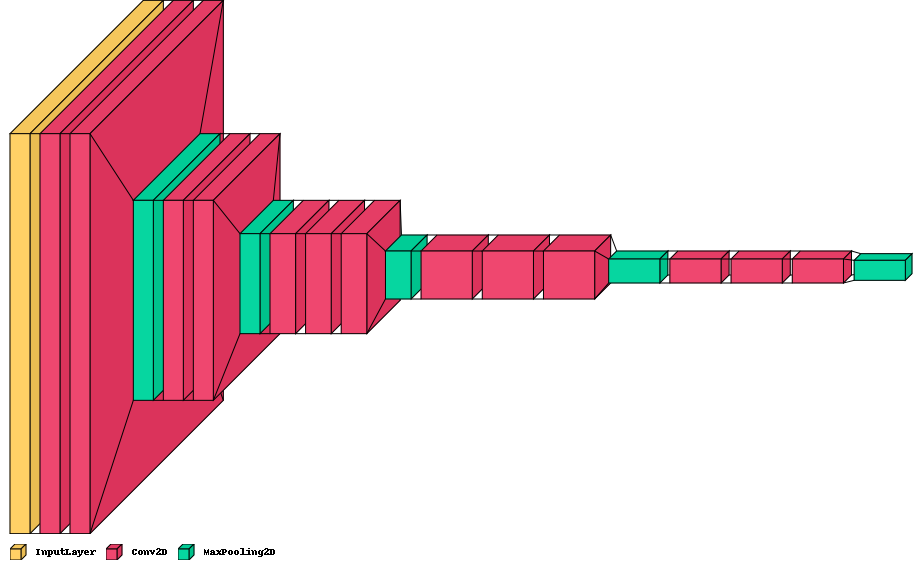

In [3]:
visualkeras.layered_view(conv_base).show()
visualkeras.layered_view(conv_base,legend=True)

In [4]:
conv_base.summary() # Print a Summary of the VGG-16 Architecture 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

## Extracting features using this pretrained convolutional base

In [5]:
train_dir = '/content/fruits-360_dataset/fruits-360/Training'
test_dir = '/content/fruits-360_dataset/fruits-360/Test'


In [7]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #split for validation
    validation_split=0.2)

train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    shuffle=True,# IMPORTANT , shuffle the dataset
    subset='training'# set as training data
)




Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.


In [ ]:

val_ds = train_gen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(100, 100),
    batch_size=32,
    subset='validation') # set as validation data


In [8]:

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    shuffle=True)

Found 22688 images belonging to 131 classes.


In [10]:
from keras import models,layers


Here we define the model to be executed, similar to XCeption, with layers representing the following: 

- Flatten() : flattens the 3d tensor into a 2D Shape

In [15]:
def build_model(alpha=0.05):
    conv_base = keras.applications.vgg16.VGG16(
                            weights="imagenet",
                            include_top=False, # include the densely connected classifier on top of the network
                            input_shape=(100, 100, 3)) 
    
    conv_base.trainable = False # Freeze the convolutional base 

    model = models.Sequential()
    
    model.add(conv_base)
    model.add(layers.Flatten())
    
    # model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
    # model.add(layers.Dropout(0.5))

    model.add(layers.Dense(131, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=alpha),       
                loss='categorical_crossentropy',
                metrics=['accuracy']
                )
    
    return model                 

In [16]:
alpha= 0.001

model = build_model(alpha=alpha)
history = model.fit(train_ds,
                        epochs=10,
                        batch_size=20,
                        validation_data=val_ds)

Epoch 1/10
1694/1694 [==============================] - 51s 30ms/step - loss: 3.3058 - accuracy: 0.4911 - val_loss: 2.1678 - val_accuracy: 0.8132
Epoch 2/10
1694/1694 [==============================] - 51s 30ms/step - loss: 1.4681 - accuracy: 0.9106 - val_loss: 1.1296 - val_accuracy: 0.8969
Epoch 3/10
1694/1694 [==============================] - 48s 29ms/step - loss: 0.7654 - accuracy: 0.9614 - val_loss: 0.6790 - val_accuracy: 0.9245
Epoch 4/10
1694/1694 [==============================] - 48s 28ms/step - loss: 0.4462 - accuracy: 0.9791 - val_loss: 0.4609 - val_accuracy: 0.9393
Epoch 5/10
1694/1694 [==============================] - 49s 29ms/step - loss: 0.2827 - accuracy: 0.9874 - val_loss: 0.3340 - val_accuracy: 0.9515
Epoch 6/10
1694/1694 [==============================] - 50s 29ms/step - loss: 0.1904 - accuracy: 0.9913 - val_loss: 0.2626 - val_accuracy: 0.9550
Epoch 7/10
1694/1694 [==============================] - 49s 29ms/step - loss: 0.1350 - accuracy: 0.9932 - val_loss: 0.2140 -

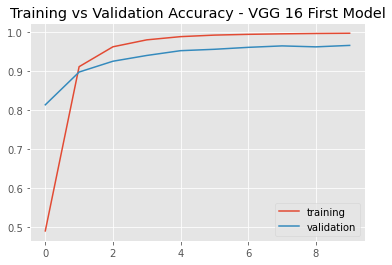

In [44]:
plt.plot(history.history['accuracy'],label='training')
plt.title("Training vs Validation Accuracy - VGG 16 First Model")
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()

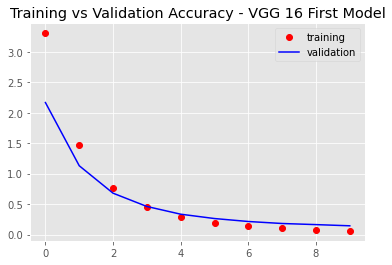

In [43]:
plt.plot(history.history['loss'],'ro',label='training')
plt.title("Training vs Validation Accuracy - VGG 16 First Model")
plt.plot(history.history['val_loss'],'b',label='validation')
plt.legend()

In [17]:
model.evaluate(test_ds)



709/709 [==============================] - 25s 36ms/step - loss: 0.3685 - accuracy: 0.9200


[0.3684837520122528, 0.91995769739151]

91 % accuracy on the test dataset ! That's really impressive considering no parameter has been tuned yet. 

## Fine-tuning this model using keras

Fine-tuning is a widely used technique for model reuse, it basically allows for more abstract representations of the reused model, and with that allow it to be more relevant for the current problem. 

This code allows the freezing of all layers until the fourth to the last:
```python
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False
```

In [50]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

Basically, it would freeze all the layers up to `black4_conv2` , and allows to make  the last 4 layers `block5_conv1`, `block5_conv2`, and `block5_conv3` trainable.

In [51]:
def build_model(alpha=0.05):
    conv_base = keras.applications.vgg16.VGG16(
                            weights="imagenet",
                            include_top=False, # include the densely connected classifier on top of the network
                            input_shape=(100, 100, 3)) 
    

    conv_base.trainable = True

    for layer in conv_base.layers[:-4]:
        layer.trainable = False # this code allows

    model = models.Sequential()
    
    model.add(conv_base)
    model.add(layers.Flatten())
    
    # model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
    # model.add(layers.Dropout(0.5))

    model.add(layers.Dense(131, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=alpha),       
                loss='categorical_crossentropy',
                metrics=['accuracy']
                )
    
    return model                 

In [30]:
alpha= 0.001

model = build_model(alpha=alpha)
history = model.fit(train_ds,
                        epochs=10,
                        batch_size=20,
                        validation_data=val_ds)

Epoch 1/30
  47/1694 [..............................] - ETA: 55s - loss: 0.0758 - accuracy: 0.9774

KeyboardInterrupt: ignored